In [2]:
# ========= Extend the previous notebook =========
import math
import numpy as np
import torch
import einops
import matplotlib.pyplot as plt

device = "cpu"
dtype  = torch.float32

# Grid sizes (tweak freely)
B = 4000
V, T, H, W = 8, 6, 16, 32
S = H * W

# Dirichlet concentrations
alpha_t           = 0.5     # sharp time
alpha_v           = 3.0     # softer variables (global)
alpha_s          = 1.0     # softer spatial (global)


# ---------- Helpers ----------
def gumbel_like(x, eps=None):
    if eps is None:
        eps = max(1e-6, torch.finfo(x.dtype).eps)
    u = torch.rand_like(x, device=x.device, dtype=x.dtype).clamp_(eps, 1 - eps)
    return -torch.log(-torch.log(u))

def safe_logit(p, eps=None):
    if eps is None:
        eps = max(1e-6, torch.finfo(p.dtype).eps)
    p = p.clamp(min=eps, max=1 - eps)
    return torch.log(p) - torch.log1p(-p)

def dirichlet_1d(B, K, alpha, *, device=device, dtype=dtype):
    conc = torch.full((B, K), float(alpha), device=device, dtype=dtype) * torch.linspace(0.75, 1.25, K)
    g = torch.distributions.Gamma(conc, torch.ones_like(conc)).sample()
    return g / g.sum(dim=-1, keepdim=True)

# ---------- Base samples (reused across methods for fair comparison) ----------
with torch.no_grad():
    # Marginals
    p_t = dirichlet_1d(B, T, alpha_t)
    p_t = einops.repeat(p_t, "b t -> b v t s", v=V, s=S)

    p_v = dirichlet_1d(B, V, float(alpha_v))
    p_v = einops.repeat(p_v, "b v -> b v t s", t=T, s=S)


scoresets = {
    "Logit sum": (safe_logit(p_t) + safe_logit(p_v)).reshape(B, V * T * H * W),
    "Log sum": (p_t.log() + p_v.log()).reshape(B, V * T * H * W),
    "Product logit": (safe_logit(p_t * p_v)).reshape(B, V * T * H * W),
}

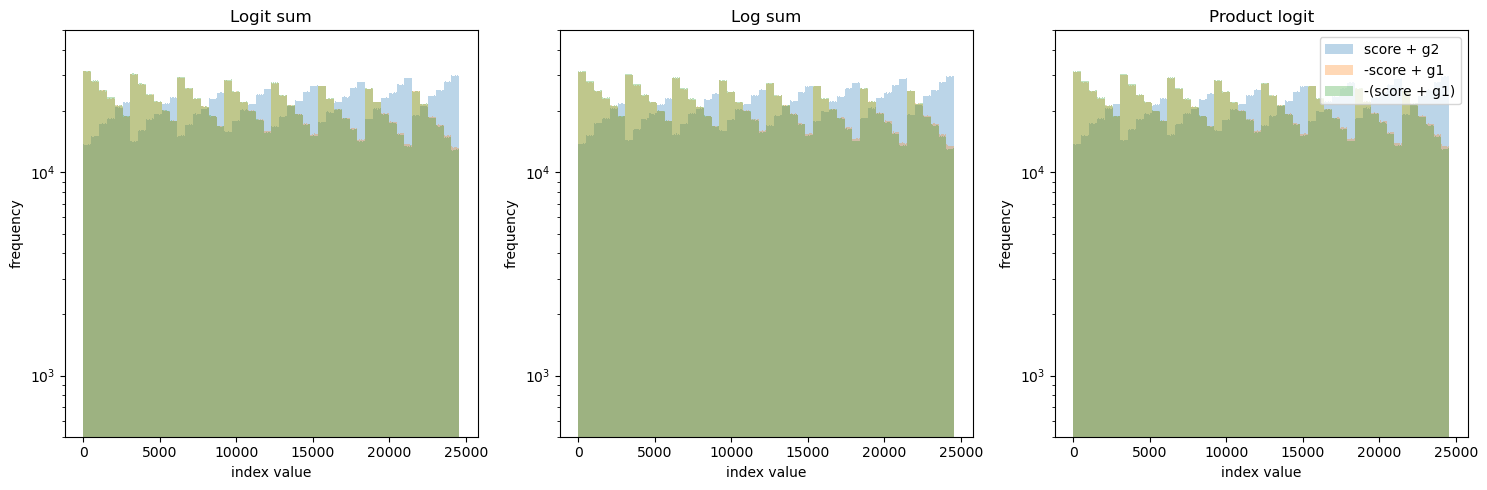

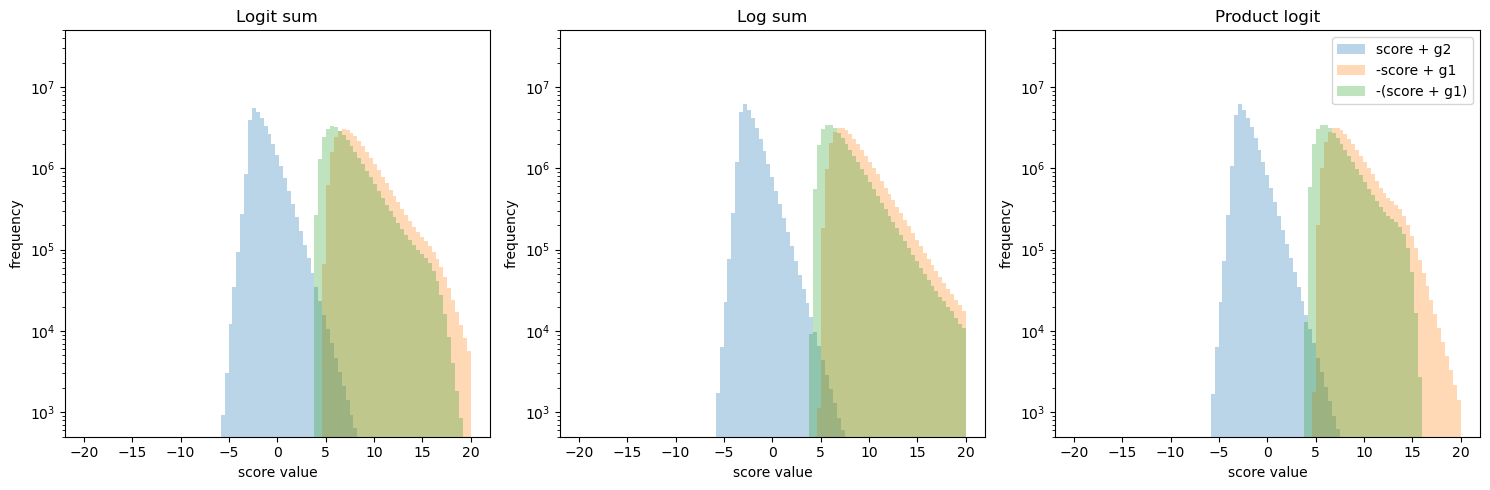

In [11]:
N = V * T * H * W
k = 8192
bins = np.arange(1, N+1, H)  # bin every index
#bins = np.linspace(-20, 20, 100)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
g1 = gumbel_like(torch.empty((B, V * T * H * W), device=device, dtype=dtype))
g2 = gumbel_like(torch.empty((B, V * T * H * W), device=device, dtype=dtype))

for ax, (name, scores) in zip(axs.flatten(), scoresets.items()):
    sc = scores + g2
    nsc = -scores + g1
    nsc2 = -(scores + g1)
    for s, l in zip([sc, nsc, nsc2], ["score + g2", "-score + g1", "-(score + g1)"]):
        ids = s.topk(k).indices.reshape(-1).cpu().numpy()
        ax.hist(ids, bins=bins, alpha=0.3, label=l)
    
    ax.set_title(name)
    ax.set_yscale("log")
    ax.set_xlabel("index value")
    ax.set_ylabel("frequency")
    ax.set_ylim(5e2, 5e4)
plt.legend()
plt.tight_layout()
plt.show()


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
bins = np.linspace(-20, 20, 100)

g1 = gumbel_like(torch.empty((B, V * T * H * W), device=device, dtype=dtype))
g2 = gumbel_like(torch.empty((B, V * T * H * W), device=device, dtype=dtype))

for ax, (name, scores) in zip(axs.flatten(), scoresets.items()):
    sc = scores + g2
    nsc = -scores + g1
    nsc2 = -(scores + g1)
    for s, l in zip([sc, nsc, nsc2], ["score + g2", "-score + g1", "-(score + g1)"]):
        ids = s.topk(k).values.reshape(-1).cpu().numpy()
        ax.hist(ids, bins=bins, alpha=0.3, label=l)
    
    ax.set_title(name)
    ax.set_yscale("log")
    ax.set_xlabel("score value")
    ax.set_ylabel("frequency")
    ax.set_ylim(5e2, 5e7)
plt.legend()
plt.tight_layout()
plt.show()

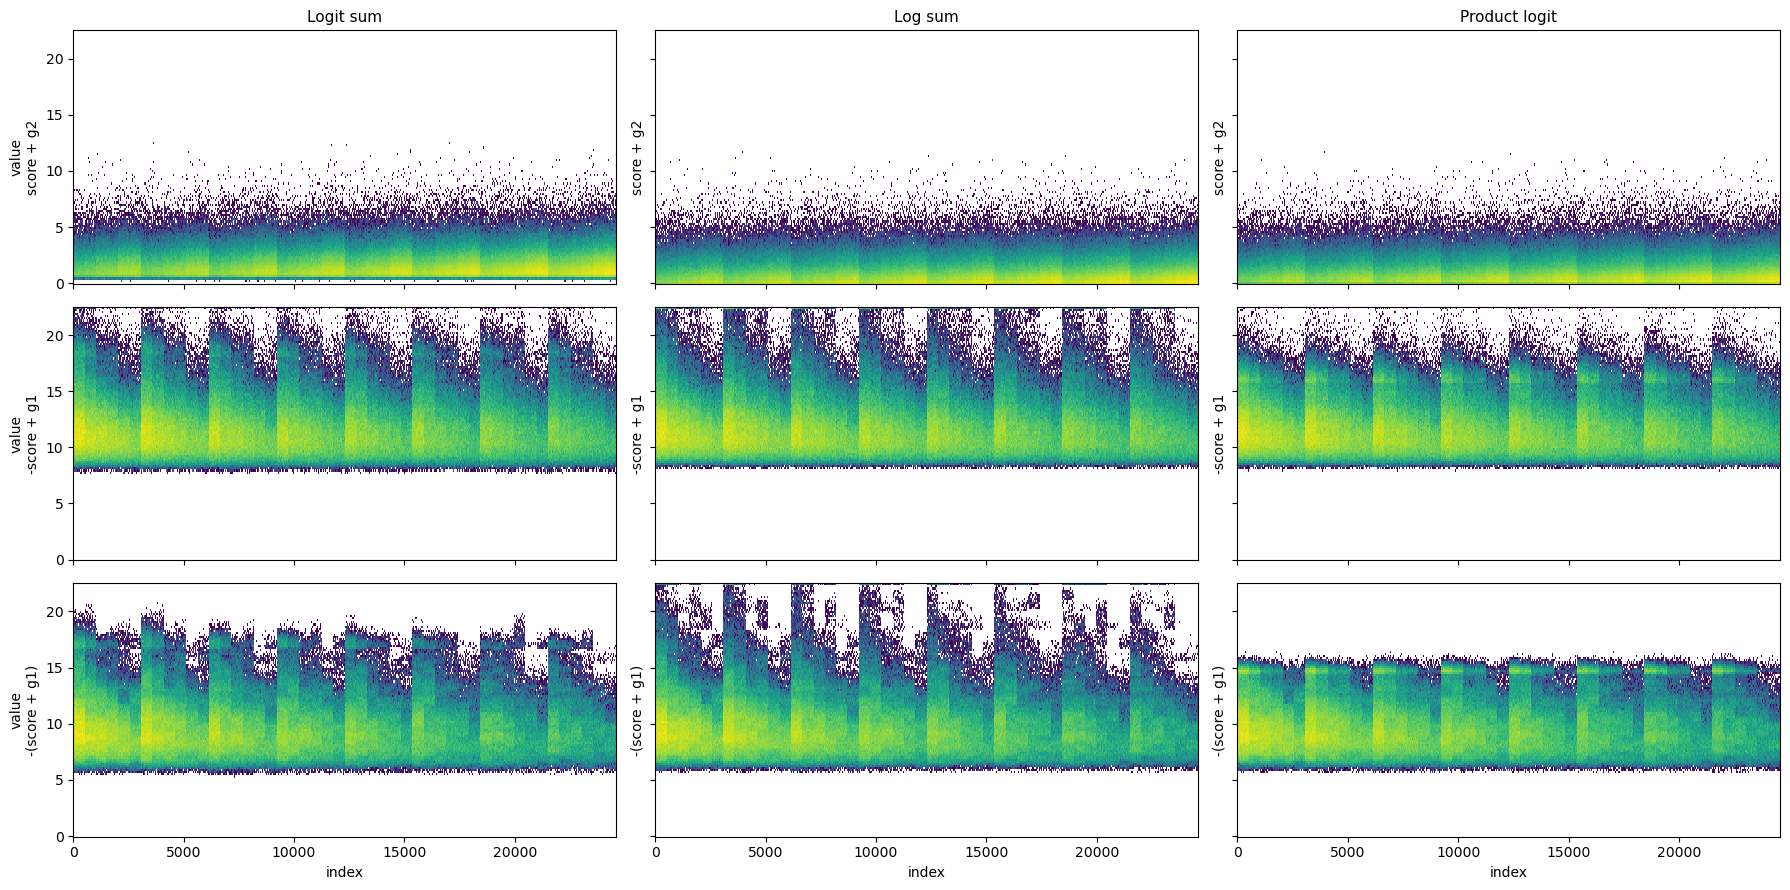

In [4]:
# 2D histograms of (topk.index, topk.value) for each score-combination × complement
# expects: scoresets (dict), B,V,T,H,W, device, dtype, gumbel_like(...)
# you can tweak k, idx_step, val_bins, and value clipping.

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# ---------- config ----------
k = 512                              # top-k per (B, :)
idx_step = max(1, H)                  # bin width along index axis (matches your earlier choice)
val_bins = 120                        # number of bins for values
clip_quantiles = (0.001, 0.999)       # clip extreme tails for more readable color scaling

# ---------- prep ----------
N = V * T * H * W
bins_idx = np.arange(0, N + 1, idx_step)  # index bins (0..N-1)
# To make value bins consistent across all panes, we’ll compute pooled min/max below.

# One shot gumbels (B, N)
g1 = gumbel_like(torch.empty((B, N), device=device, dtype=dtype))
g2 = gumbel_like(torch.empty((B, N), device=device, dtype=dtype))

# Collect all values first to define common value bins (post-clipping)
all_vals = []
pane_payload = {}  # (row_name, col_name) -> dict with 'vals' and 'idcs'

row_labels = ["score + g2", "-score + g1", "-(score + g1)"]
col_labels = list(scoresets.keys())

for col_name, scores in scoresets.items():
    phi = scores
    sc   = (phi + g2)
    nsc  = ((-phi) + g1)
    nsc2 = (-(phi + g1))

    variants = {
        "score + g2": sc,
        "-score + g1": nsc,
        "-(score + g1)": nsc2
    }

    for row_name, S in variants.items():
        topk = S.topk(k, dim=-1)
        idcs = topk.indices.reshape(-1).detach().cpu().numpy()
        vals = topk.values.reshape(-1).detach().cpu().numpy()
        pane_payload[(row_name, col_name)] = {"idcs": idcs, "vals": vals}
        all_vals.append(vals)

# pooled value range with clipping
all_vals = np.concatenate(all_vals)
vmin, vmax = np.quantile(all_vals, clip_quantiles)
bins_val = np.linspace(vmin, vmax, val_bins + 1)

# ---------- plotting ----------
fig, axs = plt.subplots(len(row_labels), len(col_labels), figsize=(18, 9), sharex='col', sharey='row')
if len(row_labels) == 1 and len(col_labels) == 1:
    axs = np.array([[axs]])

for r, row_name in enumerate(row_labels):
    for c, col_name in enumerate(col_labels):
        ax = axs[r, c]
        payload = pane_payload[(row_name, col_name)]
        # clip values to [vmin, vmax] for consistent bins
        vals = np.clip(payload["vals"], vmin, vmax)
        idcs = payload["idcs"]

        H2d, xedges, yedges = np.histogram2d(
            idcs, vals, bins=(bins_idx, bins_val)
        )
        # plot: x=index, y=value
        im = ax.pcolormesh(xedges, yedges, H2d.T, norm=LogNorm(vmin=1, vmax=max(1.0, H2d.max())), shading='auto')

        if r == 0:
            ax.set_title(col_name, fontsize=11)
        if r == len(row_labels) - 1:
            ax.set_xlabel("index")
        if c == 0:
            ax.set_ylabel(f"value\n{row_name}")
        else:
            ax.set_ylabel(row_name)

        # optional minor cosmetics
        ax.set_xlim(0, N)
        ax.set_aspect('auto')

plt.tight_layout()
plt.show()

In [7]:
# Metrics across a range of k for scoresets shaped [B, N]
# - Base:  score + g2  (tgt)
# - CompA: -score + g1  (src)
# - CompB: -(score + g1)  (alt src)
#
# Usage:
# k_values = [64, 128, 256, 512]
# metrics = metrics_over_k(scoresets, k_values, top_mass=0.8, save_json_path=None)

import torch, math, json
import numpy as np
from collections import defaultdict
from typing import Dict, List, Optional

@torch.no_grad()
def _hist_probs_from_indices(idcs: torch.Tensor, N: int) -> torch.Tensor:
    """idcs: [B, k] -> normalized histogram [N] (float)."""
    h = torch.bincount(idcs.reshape(-1), minlength=N).float()
    s = h.sum()
    return h / s.clamp_min(1.0)  # avoid div-by-zero

def _pearson(a: torch.Tensor, b: torch.Tensor) -> float:
    a = a - a.mean(); b = b - b.mean()
    denom = (a.norm() * b.norm()).clamp_min(1e-12)
    return float((a*b).sum() / denom)

def _spearman(a: torch.Tensor, b: torch.Tensor) -> float:
    # rank via argsort twice; ties are rare with floats, acceptable here
    ra = torch.argsort(torch.argsort(a))
    rb = torch.argsort(torch.argsort(b))
    ra = ra.float(); rb = rb.float()
    ra -= ra.mean(); rb -= rb.mean()
    denom = (ra.norm() * rb.norm()).clamp_min(1e-12)
    return float((ra*rb).sum() / denom)

def _js_div(p: torch.Tensor, q: torch.Tensor, eps: float = 1e-12) -> float:
    p = p.clamp_min(eps); q = q.clamp_min(eps)
    m = 0.5*(p+q)
    def _kl(a, b): return float((a * (a.log() - b.log())).sum().item())
    return 0.5*_kl(p, m) + 0.5*_kl(q, m)

def _w1_discrete_indices(p: torch.Tensor, q: torch.Tensor) -> float:
    # edges are unit-spaced 0..N-1, so W1 = sum |CDF_p - CDF_q|
    cdf_p = torch.cumsum(p, dim=0)
    cdf_q = torch.cumsum(q, dim=0)
    return float(torch.abs(cdf_p - cdf_q).sum().item())

def _entropy(p: torch.Tensor, eps: float = 1e-12) -> float:
    p = p.clamp_min(eps)
    return float((-p * p.log()).sum().item())

def _gini(p: torch.Tensor) -> float:
    s, _ = torch.sort(p)
    cdf = torch.cumsum(s, dim=0)
    n = p.numel()
    denom = (n * cdf[-1]).clamp_min(1e-12)
    return float(1.0 - 2.0 * (cdf.sum() / denom).item())

def _top_mass_overlap(p: torch.Tensor, q: torch.Tensor, mass: float = 0.8) -> float:
    def top_set(x):
        idx = torch.argsort(x, descending=True)
        c = torch.cumsum(x[idx], 0)
        k = int((c < mass).sum().item()) + 1
        return set(idx[:k].tolist())
    A, B = top_set(p), top_set(q)
    return len(A & B) / max(1, len(A | B))

@torch.no_grad()
def metrics_over_k(scoresets: Dict[str, torch.Tensor],
                   k_values: List[int],
                   top_mass: float = 0.8,
                   save_json_path: Optional[str] = None):
    """
    scoresets: dict[name] -> tensor[B, N] (already combined scores)
    Returns nested dict: results[name][k] = metrics
    """
    results = defaultdict(dict)

    for name, scores in scoresets.items():
        assert scores.ndim == 2, "scores must be [B, N]"
        B, N = scores.shape
        device, dtype = scores.device, scores.dtype

        # independent gumbels per variant (single draw, reused across ks for comparability)
        g1 = gumbel_like(torch.empty_like(scores))
        g2 = gumbel_like(torch.empty_like(scores))

        tgt = scores + g2              # base (target)
        srcA = -scores + g1            # complement A (your preferred)
        srcB = -(scores + g1)          # complement B (near-equivalent)

        # precompute sorted indices once per variant (topk for max k) to avoid recomputation
        max_k = max(k_values)
        top_tgt = tgt.topk(max_k, dim=-1).indices    # [B, max_k]
        top_srcA = srcA.topk(max_k, dim=-1).indices
        top_srcB = srcB.topk(max_k, dim=-1).indices

        # per-series entropies/ginis depend on k (histogram mass support changes), so compute per k
        for k in k_values:
            idx_t = top_tgt[:, :k]
            idx_a = top_srcA[:, :(N - k)]
            idx_b = top_srcB[:, :(N - k)]

            p_t = _hist_probs_from_indices(idx_t, N)
            p_a = _hist_probs_from_indices(idx_a, N)
            p_b = _hist_probs_from_indices(idx_b, N)

            per_series = {
                "tgt(score+g2)": {"entropy": _entropy(p_t), "gini": _gini(p_t)},
                "src(-score+g1)": {"entropy": _entropy(p_a), "gini": _gini(p_a)},
                "src_alt(-(score+g1))": {"entropy": _entropy(p_b), "gini": _gini(p_b)},
            }

            pairwise = {
                "tgt_vs_srcA": {
                    "Pearson": _pearson(p_t, p_a),
                    "Spearman": _spearman(p_t, p_a),
                    "JS_divergence": _js_div(p_t, p_a),
                    "Wasserstein_1D": _w1_discrete_indices(p_t, p_a),
                    f"Top{int(top_mass*100)}%_mass_overlap": _top_mass_overlap(p_t, p_a, mass=top_mass),
                },
                "tgt_vs_srcB": {
                    "Pearson": _pearson(p_t, p_b),
                    "Spearman": _spearman(p_t, p_b),
                    "JS_divergence": _js_div(p_t, p_b),
                    "Wasserstein_1D": _w1_discrete_indices(p_t, p_b),
                    f"Top{int(top_mass*100)}%_mass_overlap": _top_mass_overlap(p_t, p_b, mass=top_mass),
                },
                "srcA_vs_srcB": {
                    "Pearson": _pearson(p_a, p_b),
                    "Spearman": _spearman(p_a, p_b),
                    "JS_divergence": _js_div(p_a, p_b),
                    "Wasserstein_1D": _w1_discrete_indices(p_a, p_b),
                    f"Top{int(top_mass*100)}%_mass_overlap": _top_mass_overlap(p_a, p_b, mass=top_mass),
                }
            }

            results[name][int(k)] = {
                "per_series": per_series,
                "pairwise": pairwise,
                "meta": {"B": int(B), "N": int(N)}
            }

    # Optional JSON save (plain floats)
    if save_json_path is not None:
        def to_builtin(x):
            if isinstance(x, dict):
                return {k: to_builtin(v) for k, v in x.items()}
            if isinstance(x, (list, tuple)):
                return [to_builtin(v) for v in x]
            if isinstance(x, (float, int, str, bool)) or x is None:
                return x
            if isinstance(x, np.generic):
                return x.item()
            return float(x)
        with open(save_json_path, "w") as f:
            json.dump(to_builtin(results), f, indent=2)
        print(f"Saved metrics to: {save_json_path}")

    return results

In [8]:
k_values = [2**i for i in np.arange(6, 15, 2)]
metrics = metrics_over_k(scoresets, k_values, top_mass=0.8, save_json_path=None)

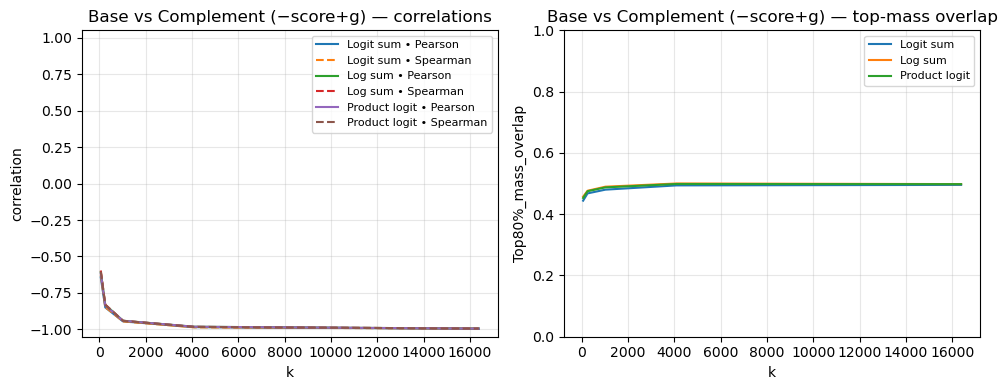

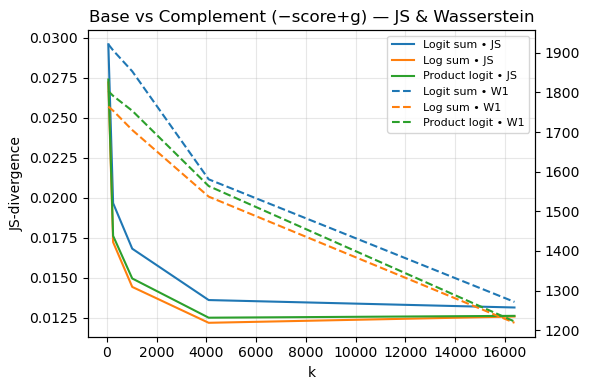

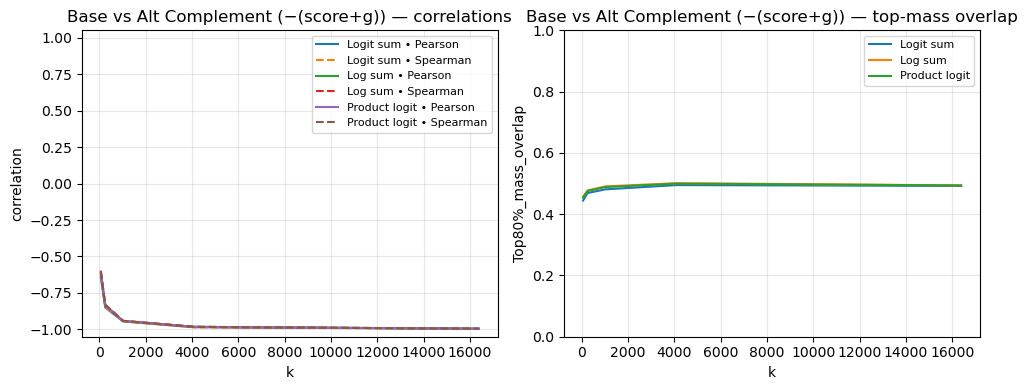

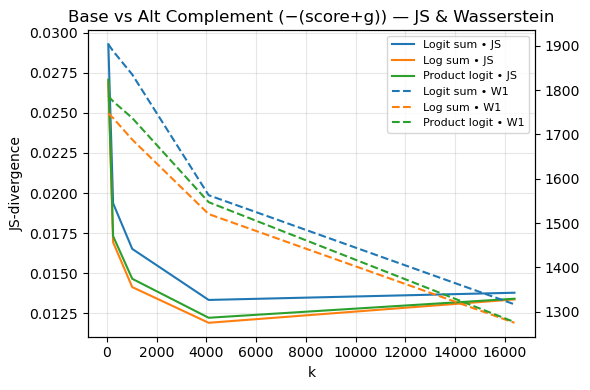

In [9]:
import matplotlib.pyplot as plt

def _overlap_key(sample_pairwise: dict) -> str:
    # Find the "TopXX%_mass_overlap" key without hardcoding XX
    for k in sample_pairwise.keys():
        if k.startswith("Top") and k.endswith("_mass_overlap"):
            return k
    raise KeyError("TopXX%_mass_overlap key not found")

def plot_k_curves(metrics):
    combos = list(metrics.keys())
    # sniff the overlap key from the first available entry
    first_combo = combos[0]
    first_k = next(iter(metrics[first_combo].keys()))
    overlap_k = _overlap_key(metrics[first_combo][first_k]["pairwise"]["tgt_vs_srcA"])

    pairs = ["tgt_vs_srcA", "tgt_vs_srcB"]   # base vs complementA/B
    titles = {"tgt_vs_srcA": "Base vs Complement (−score+g)",
              "tgt_vs_srcB": "Base vs Alt Complement (−(score+g))"}

    for pair in pairs:
        # --- gather series ---
        series = {}
        for combo in combos:
            ks = sorted(metrics[combo].keys())
            pear = [metrics[combo][k]["pairwise"][pair]["Pearson"] for k in ks]
            spear = [metrics[combo][k]["pairwise"][pair]["Spearman"] for k in ks]
            overlap = [metrics[combo][k]["pairwise"][pair][overlap_k] for k in ks]
            js = [metrics[combo][k]["pairwise"][pair]["JS_divergence"] for k in ks]
            w1 = [metrics[combo][k]["pairwise"][pair]["Wasserstein_1D"] for k in ks]
            series[combo] = {"k": ks, "pear": pear, "spear": spear,
                             "overlap": overlap, "js": js, "w1": w1}

        # --- Fig 1: corr + overlap ---
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        ax1, ax2 = axs

        for combo, s in series.items():
            ax1.plot(s["k"], s["pear"], label=f"{combo} • Pearson")
            ax1.plot(s["k"], s["spear"], linestyle="--", label=f"{combo} • Spearman")
            ax2.plot(s["k"], s["overlap"], label=combo)

        ax1.set_title(f"{titles[pair]} — correlations")
        ax1.set_xlabel("k"); ax1.set_ylabel("correlation")
        ax1.set_ylim(-1.05, 1.05)
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc="best", fontsize=8)

        ax2.set_title(f"{titles[pair]} — top-mass overlap")
        ax2.set_xlabel("k"); ax2.set_ylabel(overlap_k)
        ax2.set_ylim(0, 1)
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc="best", fontsize=8)

        plt.tight_layout()
        plt.show()

        # --- Fig 2: JS and W1 ---
        fig, ax_js = plt.subplots(1, 1, figsize=(6, 4))
        ax_w1 = ax_js.twinx()

        for combo, s in series.items():
            ax_js.plot(s["k"], s["js"], label=f"{combo} • JS")
            ax_w1.plot(s["k"], s["w1"], linestyle="--", label=f"{combo} • W1")

        ax_js.set_title(f"{titles[pair]} — JS & Wasserstein")
        ax_js.set_xlabel("k"); ax_js.set_ylabel("JS-divergence")
        ax_js.grid(True, alpha=0.3)

        # combine legends from both axes
        lines = ax_js.get_lines() + ax_w1.get_lines()
        labels = [l.get_label() for l in lines]
        ax_js.legend(lines, labels, loc="best", fontsize=8)

        plt.tight_layout()
        plt.show()

# Usage:
plot_k_curves(metrics)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import einops
import torch

In [27]:
B, V, T, H, W = 1000, 9, 6, 16, 16

In [28]:
print(torch.distributions.Binomial(H * W, torch.ones((T,)).softmax(-1)).sample((B,)).mean(0))
print(torch.distributions.Binomial(H * W, torch._sample_dirichlet(1e2 * torch.ones((B, T)).softmax(-1))).sample().mean(0))
print(torch.distributions.Binomial(H * W, torch._sample_dirichlet(1e1 * torch.ones((B, T)).softmax(-1))).sample().mean(0))
print(torch.distributions.Binomial(H * W, torch._sample_dirichlet(1e-1 * torch.ones((B, T)).softmax(-1))).sample().mean(0))

tensor([42.4460, 42.5790, 42.3850, 42.3560, 42.6160, 42.4400])
tensor([42.4580, 43.0650, 42.8240, 42.6490, 42.8150, 43.0480])
tensor([41.7360, 44.0520, 42.9330, 43.0640, 42.1890, 42.1990])
tensor([43.1870, 42.6960, 40.9270, 46.4360, 39.2280, 43.3820])


In [29]:
torch.distributions.Binomial(H * W, torch._sample_dirichlet(1e-1 * torch.ones((B, T)).softmax(-1))).sample().shape

torch.Size([1000, 6])